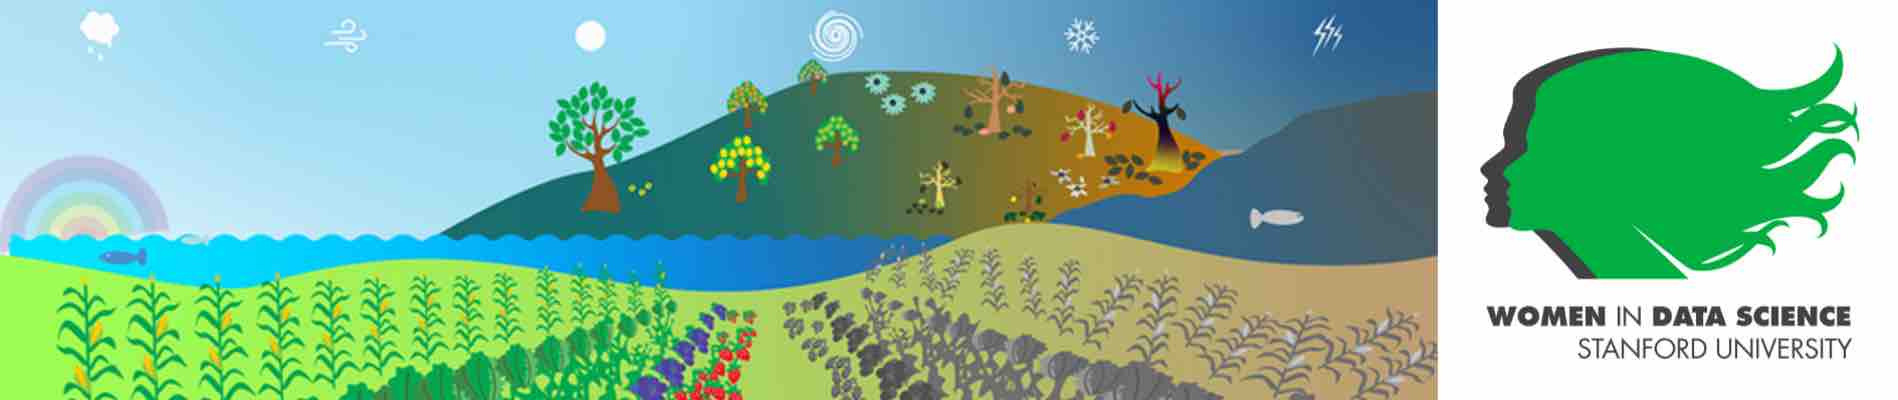

The WiDS Datathon 2023 can be viewed as a time series forecasting problem. In this data science competition, you are provided long-term weather data for multiple locations. The aim is to predict the average temperature over the next 2 weeks for each location for a given start date.

Time series forecasting has been approached with statistical methods since the 1950s (e.g. exponential smoothing, ARIMA, etc.). However, in recent years approaches using Machine Learning algorithms (hybrid models, neural networks, gradient boosted trees) have been shown to be more effective.

This Notebook will give you a **brief introduction to time series forecasting with a Machine Learning algorithm called LightGBM.**

# Import Libraries

Let's begin by importing the relevant libraries.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer

from datetime import datetime, timedelta

import lightgbm as lgb

import warnings # Supress warnings
warnings.filterwarnings("ignore")

# Experiment Tracking Setup

This step is **optional** but tracking your ML experiments can help you develop your ML models more efficiently. 
I'll be using Weights & Biases for experiment tracking.

**Disclaimer:** I am a W&B Ambassador

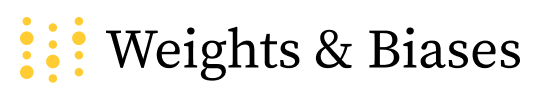


If you fork this notebook, you need to setup your own secrets API key `WANDB_API_KEY` to run this notebook. 

If you don't have an W&B account yet, you can set up one for free.
To get your API key, 
1. Go to https://wandb.ai/site and login
2. Click on your profile in the top right corner and select "Settings"
3. Scroll down to API keys and copy your key 

For more details, to set up W&B, you can check out this notebook on [ML Experiment Tracking](https://www.kaggle.com/code/ayuraj/experiment-tracking-with-weights-and-biases/notebook).

If you are new to experiment tracking, you can leave out this step or you could start with tracking your experiments with pen and paper to keep an overview of what worked and what didn't.

In [2]:
from kaggle_secrets import UserSecretsClient

import wandb
from wandb.integration.lightgbm import log_summary, wandb_callback

# Setup user secrets for login
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("WANDB_API_KEY") 

# Login
wandb.login(key = wandb_api)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Load Data

Let's load the training and the test data. The training data is the data used to build our prediction model and the test data is the data for which we make the predictions.

In [3]:
train_df = pd.read_csv('/kaggle/input/widsdatathon2023/train_data.csv')
display(train_df.head().style.set_caption('Train data'))

test_df = pd.read_csv('/kaggle/input/widsdatathon2023/test_data.csv')
display(test_df.head().style.set_caption('Test data'))

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-tmp2m-14d__tmp2m,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010-5,wind-uwnd-925-2010-6,w

We need to predict the following column:

In [4]:
target = [c for c in train_df.columns if c not in test_df.columns][0]
print(target)

contest-tmp2m-14d__tmp2m


Since we have a time series problem, let's change `startdate` to datetime format for easier handling.

In [5]:
train_df.startdate = pd.to_datetime(train_df.startdate)
test_df.startdate = pd.to_datetime(test_df.startdate)

# Exploratory Data Analysis (EDA)
Let's start with a basic EDA to get an overview of the data.

**Insight 1:** We have a time series problem but we have big time gap between the training and the testing data.

This might actually be the biggest challenge of this competition.

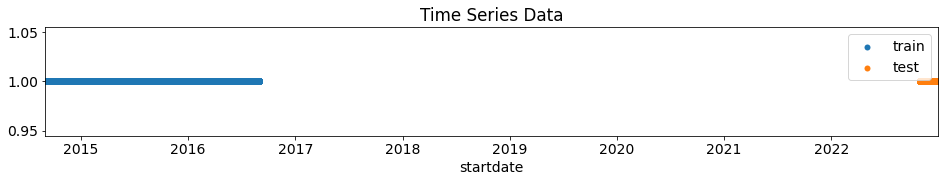

In [6]:
fig, ax = plt.subplots(1,1, figsize=(16,2))
ax.set_title('Time Series Data')
sns.scatterplot(data = train_df, x = 'startdate', y = 1, marker='o', linewidth=0, label = 'train')
sns.scatterplot(data = test_df, x = 'startdate', y = 1, marker='o', linewidth=0, label = 'test')
ax.set_xlim([train_df['startdate'].iloc[0], test_df['startdate'].iloc[-1]])
plt.show()

**Insight 2**: For each date, we have 514 unique values. This means, we have 514 unique locations.

In [7]:
train_df.groupby('startdate')[target].count()

startdate
2014-09-01    514
2014-09-02    514
2014-09-03    514
2014-09-04    514
2014-09-05    514
             ... 
2016-08-27    514
2016-08-28    514
2016-08-29    514
2016-08-30    514
2016-08-31    514
Name: contest-tmp2m-14d__tmp2m, Length: 731, dtype: int64

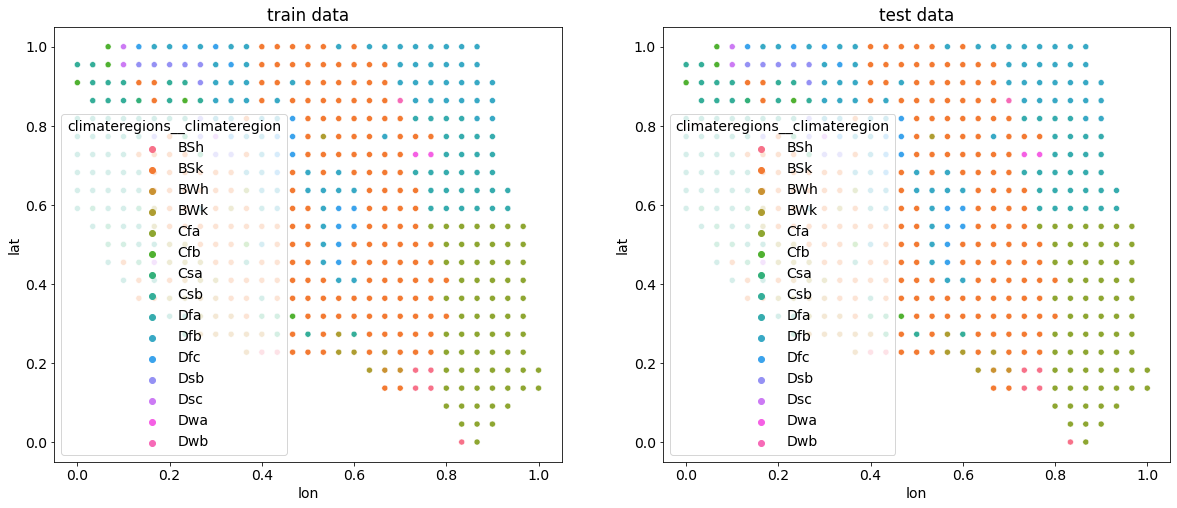

In [8]:
temp = train_df.groupby(['climateregions__climateregion', 'lat', 'lon']).size().to_frame().reset_index(drop=False)
fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.scatterplot(data=temp, y='lat', x='lon', hue='climateregions__climateregion', ax=ax[0])
ax[0].set_title('train data')
temp = test_df.groupby(['climateregions__climateregion', 'lat', 'lon']).size().to_frame().reset_index(drop=False)
sns.scatterplot(data=temp, y='lat', x='lon', hue='climateregions__climateregion', ax=ax[1])
ax[1].set_title('test data')
plt.show()

Let's create a location feature from the lat/lon coordinates.

In [9]:
# Concatenate train and test data
all_df = pd.concat([train_df, test_df], axis=0)

# Create new feature
all_df['loc_group'] = all_df.groupby(['lat','lon']).ngroup()
display(all_df)

print(f'{all_df.loc_group.nunique()} unique locations')

# Split back up
train_df = all_df.iloc[:len(train_df)]
test_df = all_df.iloc[len(train_df):]

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,loc_group
0,0,0.0,0.833333,2014-09-01,237.00,29.02,31.64,29.57,30.73,29.71,...,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58,0
1,1,0.0,0.833333,2014-09-02,228.90,29.02,31.64,29.57,30.73,29.71,...,-36.57,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42,0
2,2,0.0,0.833333,2014-09-03,220.69,29.02,31.64,29.57,30.73,29.71,...,-34.16,6.99,32.16,5.01,48.53,19.21,-33.16,15.11,4.82,0
3,3,0.0,0.833333,2014-09-04,225.28,29.02,31.64,29.57,30.73,29.71,...,-31.04,6.17,39.66,-1.41,50.59,8.29,-37.22,18.24,9.74,0
4,4,0.0,0.833333,2014-09-05,237.24,29.02,31.64,29.57,30.73,29.71,...,-31.80,7.47,38.62,-5.21,54.73,-2.58,-42.30,21.91,10.95,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31349,407083,1.0,0.866667,2022-12-27,62.72,4.60,8.71,6.05,10.08,6.39,...,-8.49,32.39,38.82,7.42,11.75,-23.62,-0.24,-5.94,51.23,574
31350,407084,1.0,0.866667,2022-12-28,73.41,4.60,8.71,6.05,10.08,6.39,...,0.83,26.23,37.64,13.01,17.84,-22.05,-3.03,1.31,51.45,574
31351,407085,1.0,0.866667,2022-12-29,70.00,4.60,8.71,6.05,10.08,6.39,...,10.90,21.06,36.53,14.15,23.12,-25.60,-5.88,9.32,45.32,574
31352,407086,1.0,0.866667,2022-12-30,79.81,4.60,8.71,6.05,10.08,6.39,...,21.37,20.42,36.05,6.38,29.00,-27.06,-1.42,16.06,31.88,574


575 unique locations


**Insight 3:** We have different locations, between training and test data

In [10]:
print('Locations in train that are not in test')
print([c for c in train_df.loc_group.unique() if c not in test_df.loc_group.unique()])

print('Locations in test that are not in train')
print([c for c in test_df.loc_group.unique() if c not in train_df.loc_group.unique()])

Locations in train that are not in test
[33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 76, 101, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 181, 210, 239, 269, 300, 330, 360, 389, 418, 447, 475, 504, 533, 559]
Locations in test that are not in train
[52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 75, 100, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 180, 209, 238, 268, 299, 329, 359, 388, 417, 446, 474, 503, 532, 558]


[Flavia Felicioni](https://www.kaggle.com/flaviafelicioni) has investigated this issue in her notebook [WiDS 2023: different locations train/test SOLVED](https://www.kaggle.com/code/flaviafelicioni/wids-2023-different-locations-train-test-solved) and found that this issue is caused due to rounding differences between training and test data.

She proposes to truncate the original latitude/longitude coordinates and re-create the location features.

In [11]:
scale = 14

train_df.loc[:,'lat']=round(train_df.lat,scale)
train_df.loc[:,'lon']=round(train_df.lon,scale)

test_df.loc[:,'lat']=round(test_df.lat,scale)
test_df.loc[:,'lon']=round(test_df.lon,scale)

# Concatenate train and test data
all_df = pd.concat([train_df, test_df], axis=0)

# Create new feature
all_df['loc_group'] = all_df.groupby(['lat','lon']).ngroup()
display(all_df)

print(f'{all_df.loc_group.nunique()} unique locations')

# Split back up
train_df = all_df.iloc[:len(train_df)]
test_df = all_df.iloc[len(train_df):]

print('Locations in train that are not in test')
print([c for c in train_df.loc_group.unique() if c not in test_df.loc_group.unique()])

print('Locations in test that are not in train')
print([c for c in test_df.loc_group.unique() if c not in train_df.loc_group.unique()])

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,loc_group
0,0,0.0,0.833333,2014-09-01,237.00,29.02,31.64,29.57,30.73,29.71,...,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58,0
1,1,0.0,0.833333,2014-09-02,228.90,29.02,31.64,29.57,30.73,29.71,...,-36.57,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42,0
2,2,0.0,0.833333,2014-09-03,220.69,29.02,31.64,29.57,30.73,29.71,...,-34.16,6.99,32.16,5.01,48.53,19.21,-33.16,15.11,4.82,0
3,3,0.0,0.833333,2014-09-04,225.28,29.02,31.64,29.57,30.73,29.71,...,-31.04,6.17,39.66,-1.41,50.59,8.29,-37.22,18.24,9.74,0
4,4,0.0,0.833333,2014-09-05,237.24,29.02,31.64,29.57,30.73,29.71,...,-31.80,7.47,38.62,-5.21,54.73,-2.58,-42.30,21.91,10.95,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31349,407083,1.0,0.866667,2022-12-27,62.72,4.60,8.71,6.05,10.08,6.39,...,-8.49,32.39,38.82,7.42,11.75,-23.62,-0.24,-5.94,51.23,513
31350,407084,1.0,0.866667,2022-12-28,73.41,4.60,8.71,6.05,10.08,6.39,...,0.83,26.23,37.64,13.01,17.84,-22.05,-3.03,1.31,51.45,513
31351,407085,1.0,0.866667,2022-12-29,70.00,4.60,8.71,6.05,10.08,6.39,...,10.90,21.06,36.53,14.15,23.12,-25.60,-5.88,9.32,45.32,513
31352,407086,1.0,0.866667,2022-12-30,79.81,4.60,8.71,6.05,10.08,6.39,...,21.37,20.42,36.05,6.38,29.00,-27.06,-1.42,16.06,31.88,513


514 unique locations
Locations in train that are not in test
[]
Locations in test that are not in train
[]


<AxesSubplot:xlabel='startdate', ylabel='contest-tmp2m-14d__tmp2m'>

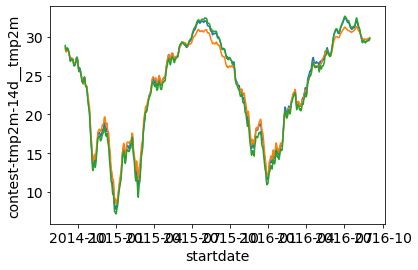

In [12]:
temp = train_df[train_df.loc_group == 0]
sns.lineplot(data=temp, x = 'startdate', y = target)
temp = train_df[train_df.loc_group == 1]
sns.lineplot(data=temp, x = 'startdate', y = target)

temp = train_df[train_df.loc_group == 2]
sns.lineplot(data=temp, x = 'startdate', y = target)

# Preprocessing

Let's check if we have any missing data and how we can handle them.

As you can see below, we have a few columns in the training data (but not in the testing data) with missing values.

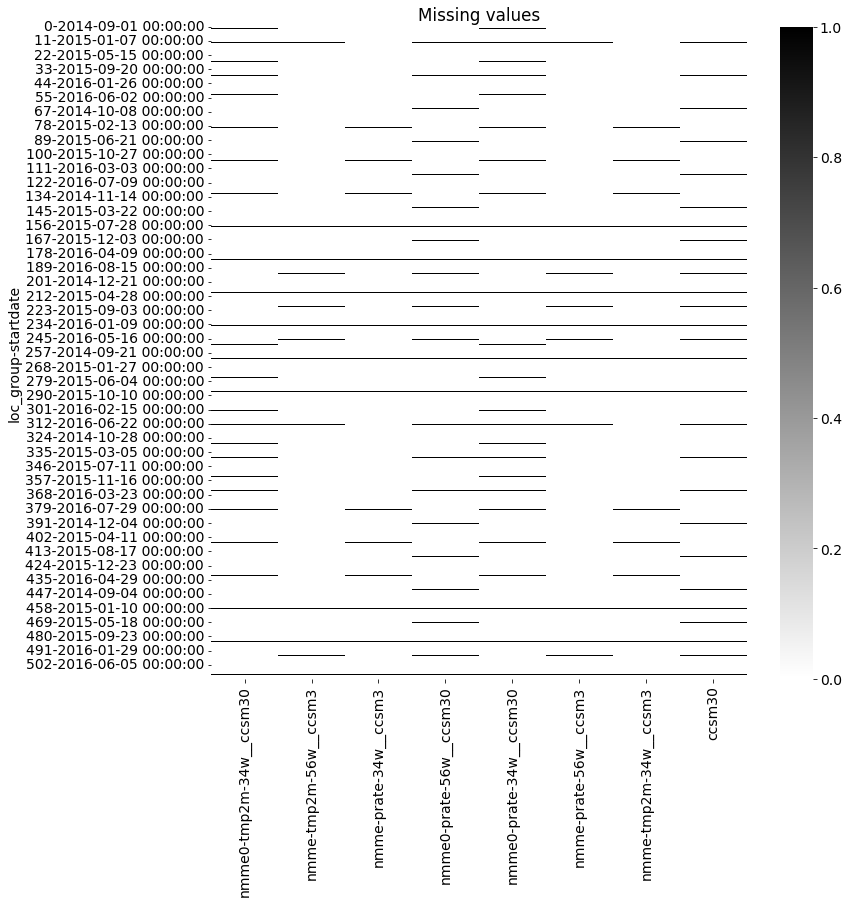

In [13]:
cols_with_missing = list(train_df.isnull().sum(axis=0)[train_df.isnull().sum(axis=0) > 0].index)

fig, ax = plt.subplots(1,1,figsize=(12,12))
sns.heatmap(train_df.set_index([ 'loc_group', 'startdate'])[cols_with_missing].isnull(), cmap='binary')
ax.set_title('Missing values')
plt.show()

In [14]:
# Save this for visualization purposes only and delete later
train_df_old = train_df.copy()
train_df_mean = train_df.sort_values(by=['loc_group', 'startdate']).fillna(20)

Often times in Machine Learning, missing values are filled with the mean value. But as you can see below in pink, filling missing values with the mean value is not ideal. Our human intuition tells us that the time series values should not drop down to the mean value where the data points are missing. Instead the values should probably be filled with some value between 27 and 30.

For this purpose, we can use the `.ffill()` method, which just uses the last observed value to fill the missing value. 

This is a popular approach to fill missing values in time series forecasting. It is also similar to the naive forecasting method. In naive forecasts, the forecast is simply the observed value. Despite its simplicity, the naive approach is a difficult baseline to beat. But think about it: If you want to forecast tomorrow's weather, a good guess would be that it will be similar to today. If it snowed today, it is quite unlikely that it is going to be hot tomorrow.

In [15]:
train_df = train_df.sort_values(by=['loc_group', 'startdate']).ffill()

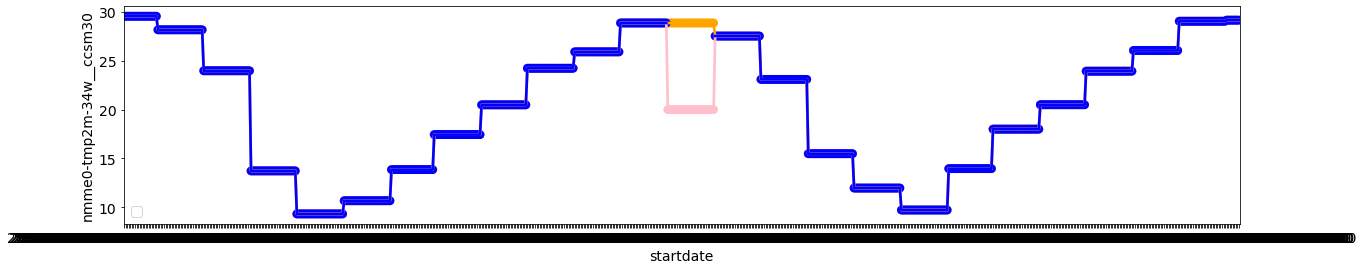

In [16]:
fig, ax = plt.subplots(1, 1,figsize=(20,4))
col_with_missing = cols_with_missing[0]
sns.pointplot(data=train_df[train_df.loc_group ==0], x='startdate', y=col_with_missing, linewidth=1, marker='.', color='orange', label='filled missing data with .ffill()' )
sns.pointplot(data=train_df_mean[train_df_mean.loc_group ==0], x='startdate', y=col_with_missing, linewidth=1, marker='.', color='pink', label='filled missing data with mean value' )
sns.pointplot(data=train_df_old[train_df_old.loc_group ==0], x='startdate', y=col_with_missing, linewidth=1, marker='.', color='blue', label='original data' )
plt.legend()
plt.show()

del train_df_old, train_df_mean

# Feature Engineering
Let's start with some basic features

## Label Encoding

In [17]:
le = preprocessing.LabelEncoder()
train_df['climateregions__climateregion'] = le.fit_transform(train_df['climateregions__climateregion'])
test_df['climateregions__climateregion'] = le.transform(test_df['climateregions__climateregion'])

## Time Features

In [18]:
def create_time_features(df):
    df = df.copy()
    #df['year'] = df.startdate.dt.year
    df['quarter'] = df.startdate.dt.quarter
    df['month'] = df.startdate.dt.month
    df['week'] = df.startdate.dt.weekofyear
    df['dayofyear'] = df.startdate.dt.day_of_year
    return df

train_df = create_time_features(train_df)
test_df = create_time_features(test_df)
train_df.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,loc_group,quarter,month,week,dayofyear
0,0,0.0,0.833333,2014-09-01,237.00,29.02,31.64,29.57,30.73,29.71,...,48.13,28.09,-13.50,11.90,4.58,0,3,9,36,244
1,1,0.0,0.833333,2014-09-02,228.90,29.02,31.64,29.57,30.73,29.71,...,48.60,27.41,-23.77,15.44,3.42,0,3,9,36,245
2,2,0.0,0.833333,2014-09-03,220.69,29.02,31.64,29.57,30.73,29.71,...,48.53,19.21,-33.16,15.11,4.82,0,3,9,36,246
3,3,0.0,0.833333,2014-09-04,225.28,29.02,31.64,29.57,30.73,29.71,...,50.59,8.29,-37.22,18.24,9.74,0,3,9,36,247
4,4,0.0,0.833333,2014-09-05,237.24,29.02,31.64,29.57,30.73,29.71,...,54.73,-2.58,-42.30,21.91,10.95,0,3,9,36,248


In [19]:
# Copied from https://colab.research.google.com/drive/10r73mOp1R7cORfeuP97V65a-rgwGyfWr?usp=sharing#scrollTo=c9ZkVb2aU-S7

def add_season(df):
    month_to_season = {
      1: 0,
      2: 0,
      3: 1,
      4: 1,
      5: 1,
      6: 2,
      7: 2,
      8: 2, 
      9: 3, 
      10: 3,
      11: 3,
      12: 0
  }
    df['season'] = df['month'].apply(lambda x: month_to_season[x])

add_season(train_df)
add_season(test_df)

In [20]:
# Copied from https://colab.research.google.com/drive/10r73mOp1R7cORfeuP97V65a-rgwGyfWr?usp=sharing#scrollTo=c9ZkVb2aU-S7

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

def encode_cyclical(df):
    # encode the day with a period of 365
    df['day_of_year_sin'] = sin_transformer(365).fit_transform(df['dayofyear'])
    df['day_of_year_cos'] = cos_transformer(365).fit_transform(df['dayofyear'])

    # encode the week with a period of 52
    df['week_sin'] = sin_transformer(52).fit_transform(df['week'])
    df['week_cos'] = cos_transformer(52).fit_transform(df['week'])

    # encode the month with a period of 12
    df['month_sin'] = sin_transformer(12).fit_transform(df['month'])
    df['month_cos'] = cos_transformer(12).fit_transform(df['month'])

    # encode the season with a period of 4
    df['season_sin'] = sin_transformer(4).fit_transform(df['season'])
    df['season_cos'] = cos_transformer(4).fit_transform(df['season'])
    
    # encode the quarter with a period of 4
    df['quarter_sin'] = sin_transformer(4).fit_transform(df['quarter'])
    df['quarter_cos'] = cos_transformer(4).fit_transform(df['quarter'])

encode_cyclical(train_df)
encode_cyclical(test_df)

In [21]:
"""# Concatenate train and test data
all_df = pd.concat([train_df, test_df], axis=0)

# Create new feature
all_df['target_loc_group_max'] = all_df.groupby(['loc_group'])[target].transform('max')
all_df['target_loc_group_min'] = all_df.groupby(['loc_group'])[target].transform('min')
all_df['target_loc_group_std'] = all_df.groupby(['loc_group'])[target].transform('std')
all_df['target_loc_group_mean'] = all_df.groupby(['loc_group'])[target].transform('mean')

all_df['target_cr_max'] = all_df.groupby(['climateregions__climateregion'])[target].transform('max')
all_df['target_cr_min'] = all_df.groupby(['climateregions__climateregion'])[target].transform('min')
all_df['target_cr_std'] = all_df.groupby(['climateregions__climateregion'])[target].transform('std')
all_df['target_cr_mean'] = all_df.groupby(['climateregions__climateregion'])[target].transform('mean')

# Split back up
train_df = all_df.iloc[:len(train_df)]
test_df = all_df.iloc[len(train_df):]"""

"# Concatenate train and test data\nall_df = pd.concat([train_df, test_df], axis=0)\n\n# Create new feature\nall_df['target_loc_group_max'] = all_df.groupby(['loc_group'])[target].transform('max')\nall_df['target_loc_group_min'] = all_df.groupby(['loc_group'])[target].transform('min')\nall_df['target_loc_group_std'] = all_df.groupby(['loc_group'])[target].transform('std')\nall_df['target_loc_group_mean'] = all_df.groupby(['loc_group'])[target].transform('mean')\n\nall_df['target_cr_max'] = all_df.groupby(['climateregions__climateregion'])[target].transform('max')\nall_df['target_cr_min'] = all_df.groupby(['climateregions__climateregion'])[target].transform('min')\nall_df['target_cr_std'] = all_df.groupby(['climateregions__climateregion'])[target].transform('std')\nall_df['target_cr_mean'] = all_df.groupby(['climateregions__climateregion'])[target].transform('mean')\n\n# Split back up\ntrain_df = all_df.iloc[:len(train_df)]\ntest_df = all_df.iloc[len(train_df):]"

# Modeling and Cross-Validation
As mentioned in the introduction, this baseline will use LightGBM for modelling. The winning solution of the M5 competition, which are a series of time series competitions,  held in 2020 used LightGBM. That's why we will be using this model for our baseline as well.

Let's begin by initializing a W&B run to track the model training as an experiment for later reference.

In [22]:
config = dict(
    competition = 'WiDS Datathom 2023',
    _wandb_kernel = 'lemon',
    seed = 42,
    learning_rate = 0.05,
    num_leaves = 32,
    max_depth = 8,
    feature_fraction = 0.5,
)

run = wandb.init(project = "WiDS-Datathon-2023",
                 name = f"Run_{datetime.now().strftime('%d%m%Y%H%M%S')}", 
                 notes = "increase learning rate",
                 tags = [],
                 config = config,
)

wandb: Currently logged in as: iamleonie. Use `wandb login --relogin` to force relogin


When working with time series a common pitfall is the usage of the wrong type of cross validation. While KFold cross validation is a popular technique in regular Machine Learning problems, it causes data leakage in time series problems. 
To avoid using future data to make predictions about the past, you need to make sure you are validating your predictions on future data points, the model has not seen during training.

The below figure illustrates two common cross validation strategies.

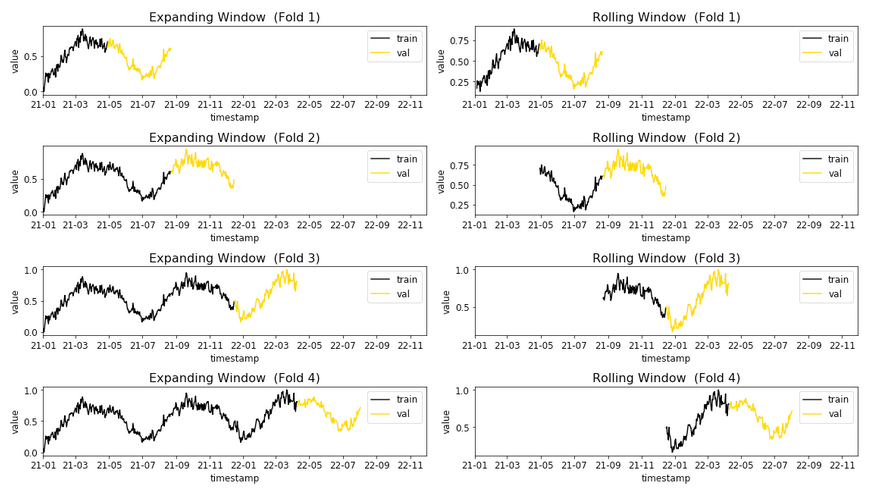

(Image by the author, originally published in [A Gentle Introduction to Time Series Analysis & Forecasting](https://wandb.ai/iamleonie/A-Gentle-Introduction-to-Time-Series-Analysis-Forecasting/reports/A-Gentle-Introduction-to-Time-Series-Analysis-Forecasting--VmlldzoyNjkxOTMz))

Below, I am using the expanding window cross validation strategy with 5 folds and a fixed length of 2 weeks for the validation data (similarly to the test set).
An alternative idea would be to cross validate year-wise.

In [23]:
exclude_cols = ['index', 'startdate']
features = [c for c in train_df.columns if ((c != target) & (c not in exclude_cols))]

N_FOLDS = 5

for fold in range(N_FOLDS):
    training_date = train_df['startdate'].max() - timedelta(14) * (N_FOLDS-fold)
    valid_date = training_date + timedelta(14)
    print(f"\nFold {fold}: \ntraining data from {train_df['startdate'].min()} to {training_date}\nvalidation data from {training_date + timedelta(1)} to {valid_date}")
    train = train_df[train_df['startdate'] <= training_date]
    val  = train_df[(train_df['startdate'] > training_date) & (train_df['startdate'] <= valid_date) ]
    
    X_train = train[features]
    y_train = train[target]

    X_val = val[features]
    y_val = val[target]

    train_ds = lgb.Dataset(X_train, label = y_train)
    valid_ds = lgb.Dataset(X_val, label = y_val)
    params = {
        'metric': 'rmse',
        'objective': 'regression',
        'force_col_wise' : True,
        'seed': config['seed'],
        'learning_rate' : config['learning_rate'],
        'num_leaves': config['num_leaves'],
        'max_depth' : config['max_depth'],
        'feature_fraction' : config['feature_fraction']
    }

    model = lgb.train(params, 
                    train_ds, 
                    num_boost_round = 1000, 
                    valid_sets = [train_ds, valid_ds], 
                      callbacks=[wandb_callback()], # Optional: Only needed when using W&B
                    early_stopping_rounds = 100,
                   verbose_eval = 200
                   )

    # Log summary to W&B
    log_summary(model, save_model_checkpoint=False)
    


Fold 0: 
training data from 2014-09-01 00:00:00 to 2016-06-22 00:00:00
validation data from 2016-06-23 00:00:00 to 2016-07-06 00:00:00
[LightGBM] [Info] Total Bins 60640
[LightGBM] [Info] Number of data points in the train set: 339754, number of used features: 259
[LightGBM] [Info] Start training from score 10.736351
Training until validation scores don't improve for 100 rounds
[200]	training's rmse: 0.867608	valid_1's rmse: 1.38048
[400]	training's rmse: 0.669478	valid_1's rmse: 1.29327
[600]	training's rmse: 0.576935	valid_1's rmse: 1.25717
[800]	training's rmse: 0.517906	valid_1's rmse: 1.23287
[1000]	training's rmse: 0.473945	valid_1's rmse: 1.21925
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.473945	valid_1's rmse: 1.21925

Fold 1: 
training data from 2014-09-01 00:00:00 to 2016-07-06 00:00:00
validation data from 2016-07-07 00:00:00 to 2016-07-20 00:00:00
[LightGBM] [Info] Total Bins 60654
[LightGBM] [Info] Number of data points in the train set: 346

# Visualizing Predictions
This might not be an essential step inthe Data Science workflow, but visualizing your results can give you a better intuition about your model's predictive capabilities.

Let's plot the best and worst 3 predictions.

In [24]:
val['y_pred']  = model.predict(X_val)

val_rmse = mean_squared_error(val[target].values,
                                           val.y_pred.values, 
                                           squared=False)

print(f'Validation RMSE: {val_rmse:.4f}')
wandb.log({"val_rmse" : val_rmse})  


def plot_predictions_for_loc_group(group):
    fig, ax = plt.subplots(1,1,figsize=(8, 6))
    temp = train[train.loc_group == group]
    sns.lineplot(data=temp, x = 'startdate', y = target, label = 'train')
    temp = val[val.loc_group == group]
    sns.lineplot(data=temp, x = 'startdate', y = target, label = 'val')
    sns.lineplot(data=temp, x = 'startdate', y = 'y_pred', label = 'pred' )
    ax.set_xlim(np.array(["2016-06-01", "2016-08-31"],
                          dtype="datetime64"))
    y_true = temp[target].values
    y_pred = temp.y_pred.values
    ax.set_title(f'RMSE {mean_squared_error(y_true, y_pred, squared=False):.4f}')
    plt.show()
    
temp = val[['startdate', 'climateregions__climateregion', 'loc_group', target, 'y_pred']]
def rmse(df):
    return mean_squared_error(df[target], df['y_pred'], squared = False)

temp = temp.groupby(['climateregions__climateregion','loc_group']).apply(rmse).reset_index()
temp.columns = ['climateregions__climateregion', 'loc_group', 'rmse']

Validation RMSE: 0.9609


### Plot Top 3 Best Predictions

,climateregions__climateregion,loc_group,rmse
438,9,417,0.245617
265,4,94,0.235334
280,4,151,0.232999
383,8,289,0.231133
268,4,97,0.217769
266,4,95,0.200044
299,4,236,0.180829
249,4,29,0.175819
267,4,96,0.166269
241,4,16,0.156651


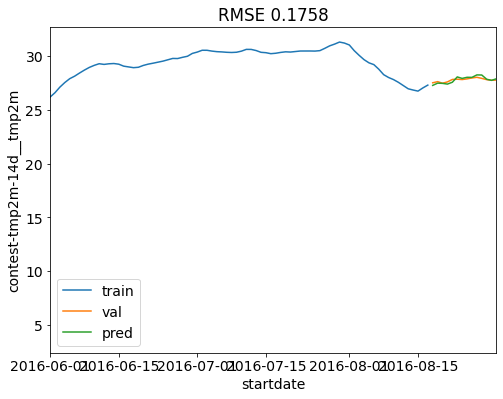

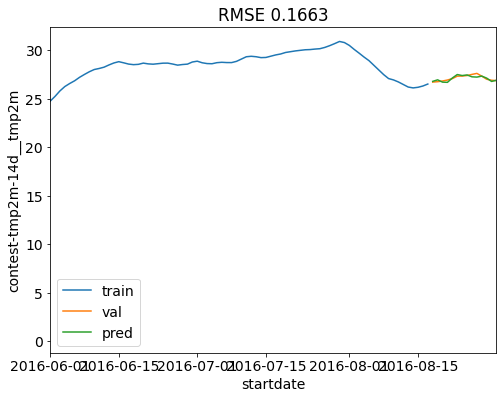

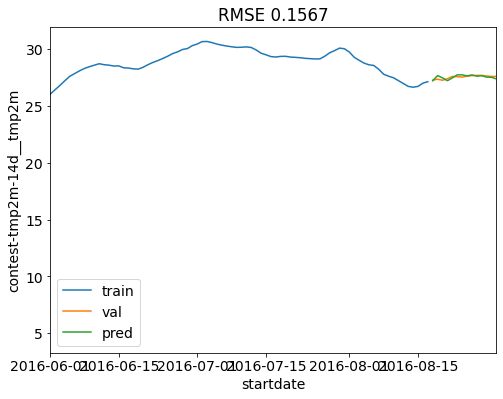

In [25]:
display(temp.sort_values(by='rmse', ascending=False).tail(10))

for i in temp.sort_values(by='rmse', ascending=False).tail(3).loc_group.values:
    plot_predictions_for_loc_group(i)

### Plot Top 3 Worst Predictions

,climateregions__climateregion,loc_group,rmse
323,7,76,2.761984
34,1,99,2.445529
307,6,52,2.273383
148,1,357,2.201019
137,1,328,2.144695
138,1,329,2.143650
124,1,300,2.045239
350,7,326,2.030924
311,6,154,2.029983
49,1,126,2.023849


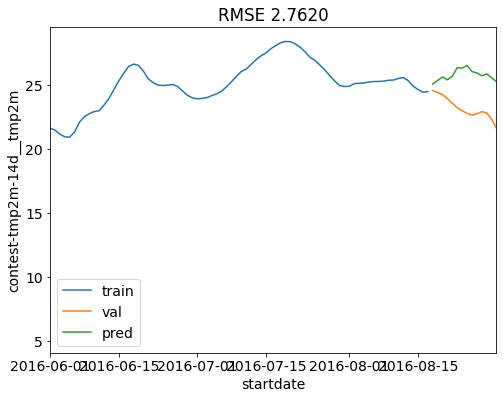

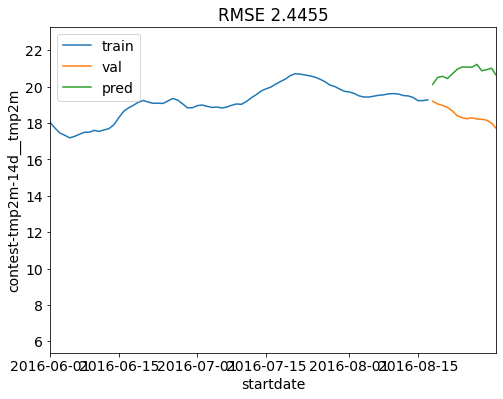

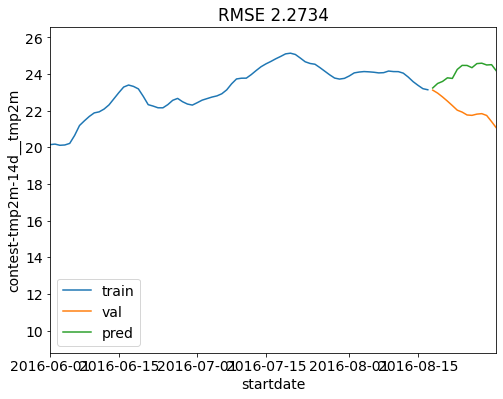

In [26]:
display(temp.sort_values(by='rmse', ascending=False).head(10))

for i in temp.sort_values(by='rmse', ascending=False).head(3).loc_group.values:
    plot_predictions_for_loc_group(i)

# Feature Importance

What's nice about using LightGBM is that you can use its built-in feature importance for some degree of AI explainability.  Below you can see the feature importance plot of the current model.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

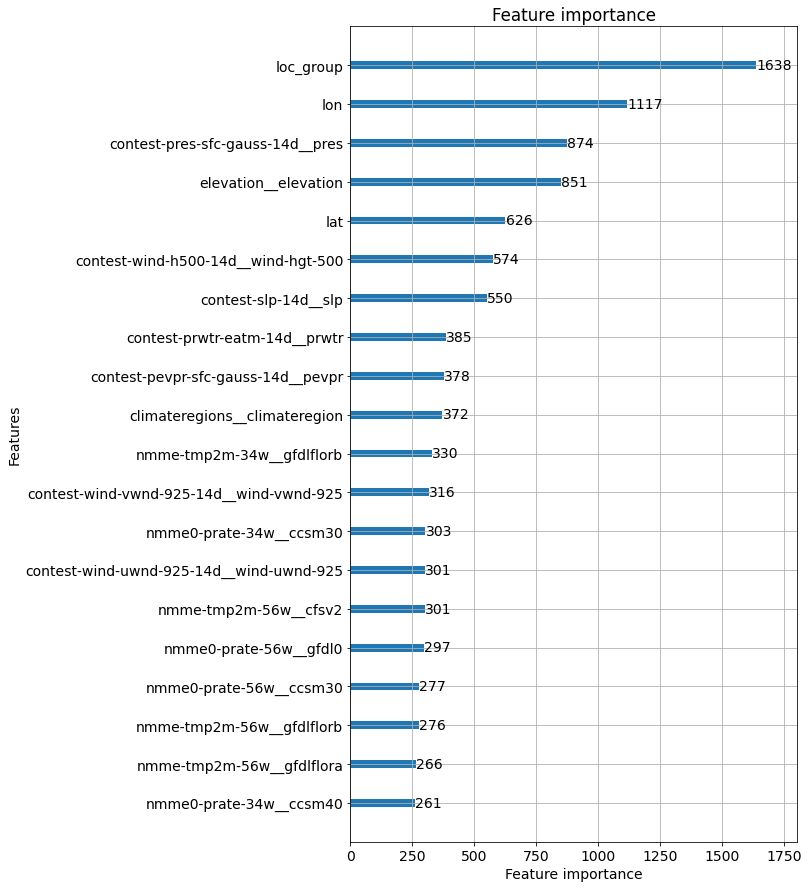

In [27]:
lgb.plot_importance(model, max_num_features=20, figsize=(8,15))

# Hyperparameter Tuning

Once the baseline is ready, we can approach hyperparameter tuning. Since I have already setup W&B for experiment tracking, I will also use it for hyperparameter tuning. If you don't have an W&B account, you can use other alternatives, like e.g. optuna.

I will be using random search to optimize the hyperparameters. To enable hyperparameter tuning, set `hyperparameter_tuning = True` in the following code block. I have disabled it here, so it doesn't run everytime I run this Notebook.

In [28]:
# Set this to True when you want to run hyperparameter tuning
hyperparameter_tuning = False

def main():
    run = wandb.init(config = config)

    # note that we define values from `wandb.config` instead 
    # of defining hard values
    params = {
        'metric': 'rmse',
        'objective': 'regression',
        'force_col_wise' : True,
        'seed': config['seed'],
        'learning_rate': run.config.learning_rate, 
        'max_depth': run.config.max_depth,
        'lambda_l1': run.config.lambda_l1,
        'lambda_l2': run.config.lambda_l2,
        'num_leaves': run.config.num_leaves,
    }

    model = lgb.train(params, 
                    train_ds, 
                    num_boost_round = 1000, 
                    valid_sets = [train_ds, valid_ds], 
                      callbacks=[wandb_callback()],
                    early_stopping_rounds = 100,
                   verbose_eval = 100
                   )

    preds = model.predict(X_val)

    val_rmse = mean_squared_error(val[target].values,
                                               preds, 
                                               squared=False)

    print(f'Validation RMSE: {val_rmse:.4f}')
    wandb.log({"val_rmse" : val_rmse})  


# Define sweep config
sweep_configuration = {
    'method': 'random',
    'name': 'sweep_grid',
    "parameters" : {
        "learning_rate": {
            "min": 0.001,
            "max": 0.5
        },
        "max_depth": {
            "min": 4,
            "max": 32
        },
        "lambda_l1": {
            "min": 0,
            "max": 100
        },
        "lambda_l2": {
            "min": 0,
            "max": 100
        },
        "num_leaves": {
            "min": 4,
            "max": 64
        },
    },
    'run_cap' : 32
}

if hyperparameter_tuning:
    # Initialize sweep by passing in config. (Optional) Provide a name of the project.
    sweep_id = wandb.sweep(sweep=sweep_configuration, project="WiDS-Datathon-2023",)

    # Start sweep job.
    wandb.agent(sweep_id, function=main)

After hyperparameter tuning, you will be left with something like this
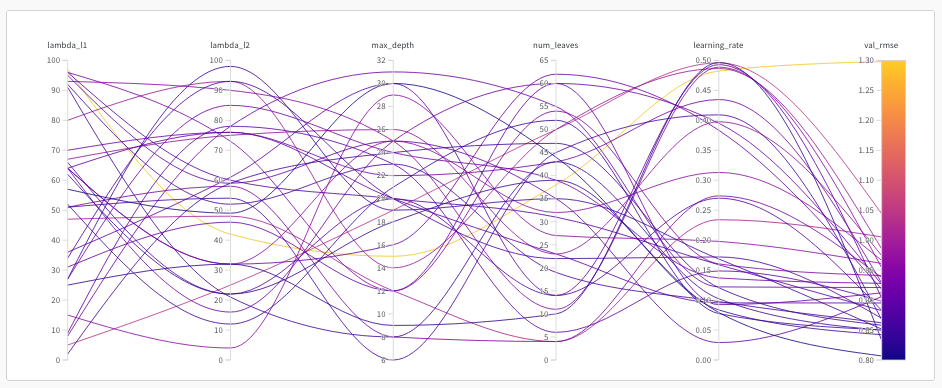

Image by the author from [W&B Sweeps Dashboard](https://wandb.ai/iamleonie/WiDS-Datathon-2023/sweeps/icwd7qpf?workspace=user-iamleonie)

# Training Model on Full Data

Once we are happy with our hyperparameters and cross-validation, we can re-run the model training on the full training dataset.

In [29]:
X_train = train_df[features]
y_train = train_df[target]

train_ds = lgb.Dataset(X_train, label = y_train)

model = lgb.train(params, 
                train_ds, 
                num_boost_round = 1000, 
                #valid_sets = [train_ds, valid_ds], 
                  callbacks=[wandb_callback()], # Optional: Only needed when using W&B
                #early_stopping_rounds = 100,
               verbose_eval = 200
               )

[LightGBM] [Info] Total Bins 60708
[LightGBM] [Info] Number of data points in the train set: 375734, number of used features: 259
[LightGBM] [Info] Start training from score 11.858568


# Prediction & Submission
Now, we are ready to make the predictions and submit them.

In [30]:
submission = pd.read_csv('/kaggle/input/widsdatathon2023/sample_solution.csv')
display(submission)
submission[target] = model.predict(test_df[features])

submission.to_csv('submission', 
                  index = False) # Set index to false to avoid issues in evaluation

,contest-tmp2m-14d__tmp2m,index
0,27.073876,375734
1,25.109308,375735
2,22.557390,375736
3,25.572875,375737
4,20.781073,375738
...,...,...
31349,28.303967,407083
31350,26.635933,407084
31351,27.057762,407085
31352,26.871066,407086
